# Driver Behaviour Prediction

# Loading Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import dill as pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from datetime import datetime

# Loading Events Data

In [2]:
#loading the dataset----------------------------------------------------------------------------
event_data = pd.read_csv('./Events Report of Drivers in Ahmedabad_16-07 to 31-07/Events Report of Drivers in Ahmedabad_16-07 to 31-07.csv',
                         index_col=None,encoding = 'ISO-8859-1')

# Checking Data

In [3]:
#Top 5 rows of dataset
event_data.head()

,Event Name,Event Time,Event Value (Upper limit =51km/h),Event Unit,Bus no.,Route Name,Stop Code,Stop Name,Latitude,Longitude
0,Idling,16.07.2018 03:05:47,180.0,Seconds,31,5U_Vasna - Naroda Gam_NORMAL,275,Vasna,23.002243,72.547849
1,Idling,16.07.2018 03:08:12,180.0,Seconds,34,6E_Narol - Odhav Talav_NORMAL,77,Narol,22.972980,72.589567
2,Idling,16.07.2018 03:08:47,180.0,Seconds,31,5U_Vasna - Naroda Gam_NORMAL,275,Vasna,23.002243,72.547849
3,Idling,16.07.2018 03:11:12,180.0,Seconds,34,6E_Narol - Odhav Talav_NORMAL,77,Narol,22.972980,72.589567
4,Idling,16.07.2018 03:12:26,180.0,Seconds,31,5U_Vasna - Naroda Gam_NORMAL,275,Vasna,23.002243,72.547849


In [4]:
#check the columns names
event_data.columns

Index(['Event Name', 'Event Time', 'Event Value (Upper limit =51km/h)',
       'Event Unit', 'Bus no.', 'Route Name', 'Stop Code', 'Stop Name',
       'Latitude', 'Longitude'],
      dtype='object')

In [5]:
#check datatypes
event_data.dtypes

Event Name                            object
Event Time                            object
Event Value (Upper limit =51km/h)    float64
Event Unit                            object
Bus no.                                int64
Route Name                            object
Stop Code                              int64
Stop Name                             object
Latitude                             float64
Longitude                            float64
dtype: object

In [6]:
#Checking missing values in data
event_data.isnull().sum()

Event Name                           0
Event Time                           0
Event Value (Upper limit =51km/h)    0
Event Unit                           0
Bus no.                              0
Route Name                           0
Stop Code                            0
Stop Name                            0
Latitude                             0
Longitude                            0
dtype: int64

In [7]:
#Creating a copy of original data
event_df = event_data.copy()

In [8]:
#info about data
event_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401399 entries, 0 to 401398
Data columns (total 10 columns):
Event Name                           401399 non-null object
Event Time                           401399 non-null object
Event Value (Upper limit =51km/h)    401399 non-null float64
Event Unit                           401399 non-null object
Bus no.                              401399 non-null int64
Route Name                           401399 non-null object
Stop Code                            401399 non-null int64
Stop Name                            401399 non-null object
Latitude                             401399 non-null float64
Longitude                            401399 non-null float64
dtypes: float64(3), int64(2), object(5)
memory usage: 30.6+ MB


In [9]:
#Summary of given data
event_df.describe()

,Event Value (Upper limit =51km/h),Bus no.,Stop Code,Latitude,Longitude
count,401399.000000,401399.000000,401399.000000,401399.000000,401399.000000
mean,30.307657,84.908936,135.329739,23.034185,72.574000
std,64.320098,78.152336,153.804614,0.035515,0.040294
min,0.130000,1.000000,1.000000,22.972530,72.447593
25%,0.284000,23.000000,36.000000,23.002548,72.547473
50%,0.328000,52.000000,86.000000,23.027772,72.581080
75%,0.426000,156.000000,213.000000,23.062650,72.593679
max,1034.000000,239.000000,2200.000000,23.129291,72.671513


# Data Cleaning and Preprocessing

In [10]:
#Data cleaning-----------------------------------------------------------------------------------

#extracting day & hour variable from given date
event_df['Day'] = [datetime.strptime(d, '%d.%m.%Y %H:%M:%S').weekday() for d in event_df['Event Time']]
event_df['Hour'] = [datetime.strptime(d, '%d.%m.%Y %H:%M:%S').hour for d in event_df['Event Time']]

In [11]:
#Renaming column names
event_df.rename(columns={'Bus no.': 'Bus_no', 'Route Name': 'Route_Name','Stop Code': 'Stop_Code','Event Unit': 'Event_Unit',
                         'Event Value (Upper limit =51km/h)': 'Event_Value','Event Name': 'Event_Name'}, inplace=True)

# Feature Engineering

In [12]:
#Feature Engineering-------------------------------------------------------------------------------

#creating three variables speed, acceleration ,and time by given variables Event value & Event unit
##Seconds -  Time variable
##m/s2 - Acceleration variable
##km/h - speed variable

#intialization of all three variables
event_df['Time'] = " "
event_df['Acceleration'] = " "
event_df['Speed'] = " "

event_df['Time'] = pd.to_numeric(np.where(event_df['Event_Unit']=='Seconds', event_df['Event_Value'],None))
event_df['Speed'] = pd.to_numeric(np.where(event_df['Event_Unit']=='km/h', event_df['Event_Value'],None))
event_df['Acceleration'] = pd.to_numeric(np.where(event_df['Event_Unit']=='m/s2', event_df['Event_Value'],None))

In [13]:
#Replace missing values in time, acceleration and speed by -1
event_df.fillna(-1,inplace = True)

In [14]:
#Converting route variable (object) to integer [Label Encoding]
cat_col = ['Route_Name']
for var in cat_col:
    le = preprocessing.LabelEncoder()
    event_df[var]=le.fit_transform(event_df[var].astype('str'))

# Feature Analysis

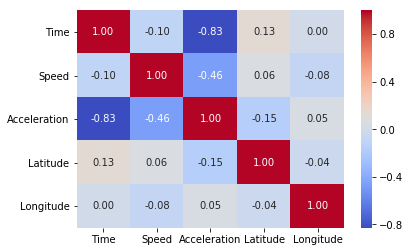

In [15]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(event_df[['Time','Speed', 'Acceleration', 'Latitude', 'Longitude']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

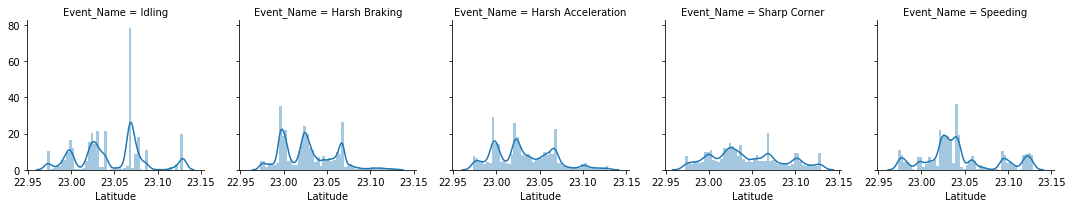

In [16]:
# Explore Latitude vs Event Name
g = sns.FacetGrid(event_df, col='Event_Name')
g = g.map(sns.distplot, "Latitude")

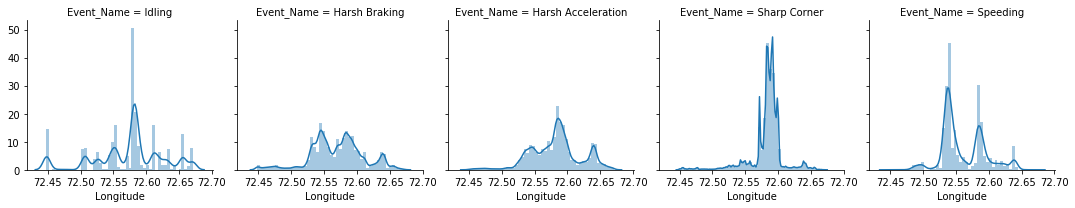

In [17]:
# Explore longitude vs Event Name
g = sns.FacetGrid(event_df, col='Event_Name')
g = g.map(sns.distplot, "Longitude")

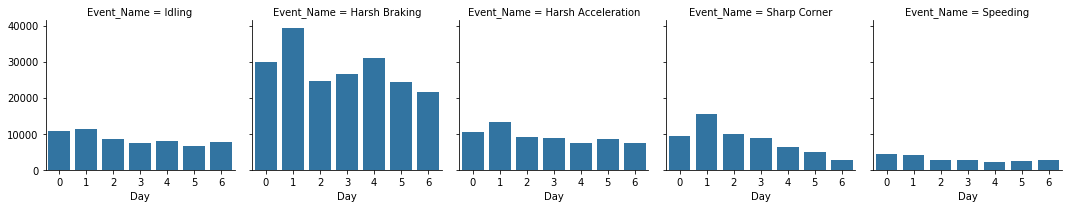

In [18]:
# Explore Day vs Event Name
g = sns.FacetGrid(event_df, col='Event_Name')
g = g.map(sns.countplot, "Day")

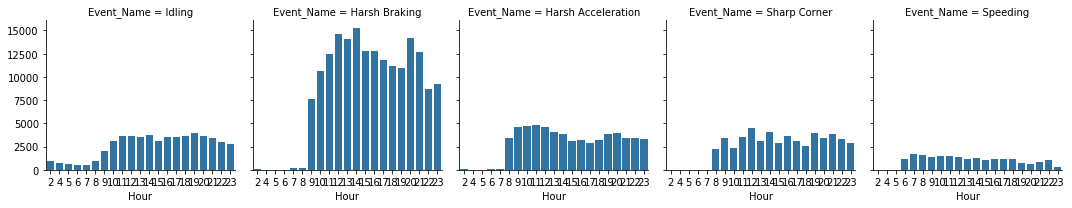

In [19]:
# Explore Hour vs Event Name
g = sns.FacetGrid(event_df, col='Event_Name')
g = g.map(sns.countplot, "Hour")

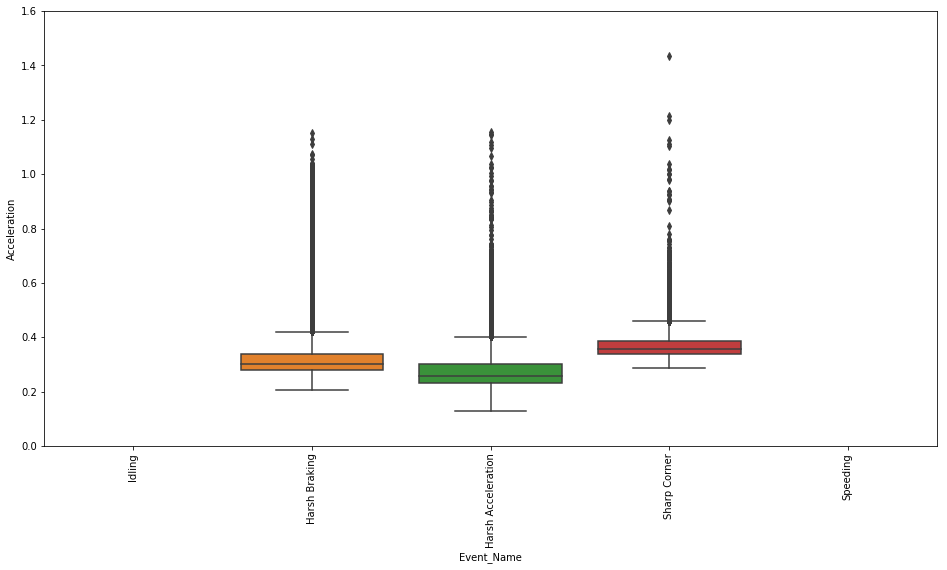

In [20]:
#Boxplot of Acceleration variables
var = 'Event_Name'
data = pd.concat([event_df['Acceleration'], event_df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y='Acceleration', data=data)
fig.axis(ymin=0, ymax=1.6);
plt.xticks(rotation=90);

# Modeling

In [21]:
#XGBoost function
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=2000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = len(np.unique(event_df['Event_Name']))
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [22]:
#Preparation data for xgboost model
#Coverting Event_Name (target) to numerical
target_num_map = {'Harsh Braking':0, 'Harsh Acceleration':1, 'Idling':2,'Sharp Corner':3, 'Speeding':4}
event_df['Event_Name'] = event_df['Event_Name'].apply(lambda x: target_num_map[x])

#features to use for prediction
cols_to_use = ['Time', 'Day', 'Hour', 'Speed', 'Acceleration', 'Latitude', 'Longitude','Bus_no','Route_Name','Stop_Code']

In [23]:
train, test = train_test_split(event_df, test_size=0.3, random_state = 45)

X_train = train.loc[:,cols_to_use]
Y_train = train['Event_Name']

X_test = test.loc[:,cols_to_use]
Y_test = test['Event_Name']

print(X_train.shape)
print(X_test.shape)

(280979, 10)
(120420, 10)


In [47]:
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(X_train.shape[0])):
        dev_X, val_X = np.array(X_train)[dev_index,:], np.array(X_train)[val_index,:]
        dev_y, val_y = np.array(Y_train)[dev_index], np.array(Y_train)[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

[0]	train-mlogloss:1.42244	test-mlogloss:1.42269
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:1.28233	test-mlogloss:1.2826
[2]	train-mlogloss:1.16097	test-mlogloss:1.16141
[3]	train-mlogloss:1.06587	test-mlogloss:1.06654
[4]	train-mlogloss:0.972017	test-mlogloss:0.972652
[5]	train-mlogloss:0.889427	test-mlogloss:0.890189
[6]	train-mlogloss:0.825062	test-mlogloss:0.825768
[7]	train-mlogloss:0.761628	test-mlogloss:0.762449
[8]	train-mlogloss:0.711474	test-mlogloss:0.712536
[9]	train-mlogloss:0.667435	test-mlogloss:0.668451
[10]	train-mlogloss:0.630241	test-mlogloss:0.631353
[11]	train-mlogloss:0.589967	test-mlogloss:0.591063
[12]	train-mlogloss:0.553126	test-mlogloss:0.554243
[13]	train-mlogloss:0.519934	test-mlogloss:0.521086
[14]	train-mlogloss:0.492078	test-mlogloss:0.493244
[15]	train-mlogloss:0.4661	test-mlogloss:0.467328
[16]	train-mlogloss:0.442245	test-mlog

[155]	train-mlogloss:0.128733	test-mlogloss:0.137338
[156]	train-mlogloss:0.128487	test-mlogloss:0.137133
[157]	train-mlogloss:0.128203	test-mlogloss:0.136937
[158]	train-mlogloss:0.128049	test-mlogloss:0.136815
[159]	train-mlogloss:0.127827	test-mlogloss:0.136669
[160]	train-mlogloss:0.127621	test-mlogloss:0.136536
[161]	train-mlogloss:0.127403	test-mlogloss:0.136344
[162]	train-mlogloss:0.127039	test-mlogloss:0.136042
[163]	train-mlogloss:0.126877	test-mlogloss:0.135941
[164]	train-mlogloss:0.126623	test-mlogloss:0.135697
[165]	train-mlogloss:0.126385	test-mlogloss:0.135525
[166]	train-mlogloss:0.126177	test-mlogloss:0.135389
[167]	train-mlogloss:0.125975	test-mlogloss:0.135225
[168]	train-mlogloss:0.12562	test-mlogloss:0.13493
[169]	train-mlogloss:0.125465	test-mlogloss:0.134829
[170]	train-mlogloss:0.125212	test-mlogloss:0.13463
[171]	train-mlogloss:0.125117	test-mlogloss:0.134585
[172]	train-mlogloss:0.124916	test-mlogloss:0.13444
[173]	train-mlogloss:0.124727	test-mlogloss:0.1342

[311]	train-mlogloss:0.101478	test-mlogloss:0.118565
[312]	train-mlogloss:0.101399	test-mlogloss:0.118529
[313]	train-mlogloss:0.101301	test-mlogloss:0.118485
[314]	train-mlogloss:0.101191	test-mlogloss:0.118432
[315]	train-mlogloss:0.101064	test-mlogloss:0.118355
[316]	train-mlogloss:0.100948	test-mlogloss:0.118253
[317]	train-mlogloss:0.100839	test-mlogloss:0.118183
[318]	train-mlogloss:0.100682	test-mlogloss:0.118049
[319]	train-mlogloss:0.100615	test-mlogloss:0.118014
[320]	train-mlogloss:0.100502	test-mlogloss:0.117954
[321]	train-mlogloss:0.100415	test-mlogloss:0.117932
[322]	train-mlogloss:0.10027	test-mlogloss:0.117819
[323]	train-mlogloss:0.10017	test-mlogloss:0.117744
[324]	train-mlogloss:0.100054	test-mlogloss:0.11765
[325]	train-mlogloss:0.099936	test-mlogloss:0.117575
[326]	train-mlogloss:0.099767	test-mlogloss:0.11747
[327]	train-mlogloss:0.099634	test-mlogloss:0.117359
[328]	train-mlogloss:0.099523	test-mlogloss:0.117321
[329]	train-mlogloss:0.099365	test-mlogloss:0.1172

[466]	train-mlogloss:0.086347	test-mlogloss:0.110512
[467]	train-mlogloss:0.08627	test-mlogloss:0.11049
[468]	train-mlogloss:0.086144	test-mlogloss:0.110402
[469]	train-mlogloss:0.08601	test-mlogloss:0.110356
[470]	train-mlogloss:0.085948	test-mlogloss:0.110361
[471]	train-mlogloss:0.085862	test-mlogloss:0.110309
[472]	train-mlogloss:0.085757	test-mlogloss:0.110259
[473]	train-mlogloss:0.085673	test-mlogloss:0.110217
[474]	train-mlogloss:0.085581	test-mlogloss:0.110189
[475]	train-mlogloss:0.085505	test-mlogloss:0.110149
[476]	train-mlogloss:0.08544	test-mlogloss:0.110131
[477]	train-mlogloss:0.085402	test-mlogloss:0.110112
[478]	train-mlogloss:0.085337	test-mlogloss:0.110083
[479]	train-mlogloss:0.085268	test-mlogloss:0.110045
[480]	train-mlogloss:0.085174	test-mlogloss:0.109984
[481]	train-mlogloss:0.085077	test-mlogloss:0.10992
[482]	train-mlogloss:0.084999	test-mlogloss:0.10989
[483]	train-mlogloss:0.084882	test-mlogloss:0.109821
[484]	train-mlogloss:0.084749	test-mlogloss:0.109709

[622]	train-mlogloss:0.075846	test-mlogloss:0.106186
[623]	train-mlogloss:0.075772	test-mlogloss:0.106127
[624]	train-mlogloss:0.075718	test-mlogloss:0.106125
[625]	train-mlogloss:0.075667	test-mlogloss:0.106108
[626]	train-mlogloss:0.075591	test-mlogloss:0.106094
[627]	train-mlogloss:0.075535	test-mlogloss:0.106067
[628]	train-mlogloss:0.075467	test-mlogloss:0.106046
[629]	train-mlogloss:0.075433	test-mlogloss:0.10602
[630]	train-mlogloss:0.075368	test-mlogloss:0.105993
[631]	train-mlogloss:0.075325	test-mlogloss:0.105969
[632]	train-mlogloss:0.075289	test-mlogloss:0.105954
[633]	train-mlogloss:0.075231	test-mlogloss:0.105941
[634]	train-mlogloss:0.075174	test-mlogloss:0.105916
[635]	train-mlogloss:0.075116	test-mlogloss:0.105901
[636]	train-mlogloss:0.075097	test-mlogloss:0.105899
[637]	train-mlogloss:0.075021	test-mlogloss:0.105885
[638]	train-mlogloss:0.074958	test-mlogloss:0.105857
[639]	train-mlogloss:0.074897	test-mlogloss:0.105833
[640]	train-mlogloss:0.074857	test-mlogloss:0.1

[778]	train-mlogloss:0.067964	test-mlogloss:0.103863
[779]	train-mlogloss:0.067905	test-mlogloss:0.103852
[780]	train-mlogloss:0.067852	test-mlogloss:0.103828
[781]	train-mlogloss:0.067787	test-mlogloss:0.103816
[782]	train-mlogloss:0.067727	test-mlogloss:0.103784
[783]	train-mlogloss:0.067669	test-mlogloss:0.103774
[784]	train-mlogloss:0.067636	test-mlogloss:0.103757
[785]	train-mlogloss:0.067601	test-mlogloss:0.103753
[786]	train-mlogloss:0.067568	test-mlogloss:0.103739
[787]	train-mlogloss:0.067515	test-mlogloss:0.103712
[788]	train-mlogloss:0.06747	test-mlogloss:0.103693
[789]	train-mlogloss:0.067425	test-mlogloss:0.103685
[790]	train-mlogloss:0.067381	test-mlogloss:0.103679
[791]	train-mlogloss:0.067341	test-mlogloss:0.103666
[792]	train-mlogloss:0.067308	test-mlogloss:0.103673
[793]	train-mlogloss:0.067237	test-mlogloss:0.103646
[794]	train-mlogloss:0.067224	test-mlogloss:0.103641
[795]	train-mlogloss:0.067175	test-mlogloss:0.10364
[796]	train-mlogloss:0.067141	test-mlogloss:0.10

[934]	train-mlogloss:0.061248	test-mlogloss:0.102144
[935]	train-mlogloss:0.061205	test-mlogloss:0.102143
[936]	train-mlogloss:0.06117	test-mlogloss:0.10214
[937]	train-mlogloss:0.061128	test-mlogloss:0.102123
[938]	train-mlogloss:0.061092	test-mlogloss:0.102101
[939]	train-mlogloss:0.061058	test-mlogloss:0.102098
[940]	train-mlogloss:0.061026	test-mlogloss:0.1021
[941]	train-mlogloss:0.060994	test-mlogloss:0.102081
[942]	train-mlogloss:0.06095	test-mlogloss:0.102069
[943]	train-mlogloss:0.060917	test-mlogloss:0.102049
[944]	train-mlogloss:0.060877	test-mlogloss:0.102047
[945]	train-mlogloss:0.060844	test-mlogloss:0.102037
[946]	train-mlogloss:0.060806	test-mlogloss:0.102041
[947]	train-mlogloss:0.060761	test-mlogloss:0.102038
[948]	train-mlogloss:0.060711	test-mlogloss:0.102029
[949]	train-mlogloss:0.06067	test-mlogloss:0.102017
[950]	train-mlogloss:0.060621	test-mlogloss:0.102003
[951]	train-mlogloss:0.060576	test-mlogloss:0.102001
[952]	train-mlogloss:0.060544	test-mlogloss:0.101995

[1088]	train-mlogloss:0.055682	test-mlogloss:0.101195
[1089]	train-mlogloss:0.055645	test-mlogloss:0.101192
[1090]	train-mlogloss:0.055611	test-mlogloss:0.101182
[1091]	train-mlogloss:0.055573	test-mlogloss:0.101176
[1092]	train-mlogloss:0.055531	test-mlogloss:0.101166
[1093]	train-mlogloss:0.055493	test-mlogloss:0.101155
[1094]	train-mlogloss:0.05546	test-mlogloss:0.101152
[1095]	train-mlogloss:0.055429	test-mlogloss:0.101143
[1096]	train-mlogloss:0.055393	test-mlogloss:0.101121
[1097]	train-mlogloss:0.055363	test-mlogloss:0.101117
[1098]	train-mlogloss:0.055332	test-mlogloss:0.10112
[1099]	train-mlogloss:0.055303	test-mlogloss:0.101111
[1100]	train-mlogloss:0.055279	test-mlogloss:0.101117
[1101]	train-mlogloss:0.055256	test-mlogloss:0.101125
[1102]	train-mlogloss:0.055217	test-mlogloss:0.10113
[1103]	train-mlogloss:0.055173	test-mlogloss:0.101117
[1104]	train-mlogloss:0.05514	test-mlogloss:0.101103
[1105]	train-mlogloss:0.0551	test-mlogloss:0.101101
[1106]	train-mlogloss:0.05506	test

[1241]	train-mlogloss:0.050943	test-mlogloss:0.100574
[1242]	train-mlogloss:0.050912	test-mlogloss:0.100579
[1243]	train-mlogloss:0.050873	test-mlogloss:0.100564
[1244]	train-mlogloss:0.050843	test-mlogloss:0.100548
[1245]	train-mlogloss:0.050814	test-mlogloss:0.100548
[1246]	train-mlogloss:0.050791	test-mlogloss:0.100542
[1247]	train-mlogloss:0.050771	test-mlogloss:0.100542
[1248]	train-mlogloss:0.050728	test-mlogloss:0.100533
[1249]	train-mlogloss:0.050694	test-mlogloss:0.100535
[1250]	train-mlogloss:0.050658	test-mlogloss:0.10053
[1251]	train-mlogloss:0.050625	test-mlogloss:0.100542
[1252]	train-mlogloss:0.050604	test-mlogloss:0.100545
[1253]	train-mlogloss:0.050564	test-mlogloss:0.100532
[1254]	train-mlogloss:0.05053	test-mlogloss:0.100527
[1255]	train-mlogloss:0.050506	test-mlogloss:0.100523
[1256]	train-mlogloss:0.050482	test-mlogloss:0.100517
[1257]	train-mlogloss:0.050443	test-mlogloss:0.100512
[1258]	train-mlogloss:0.050411	test-mlogloss:0.100497
[1259]	train-mlogloss:0.050387

In [48]:
preds, model = runXGB(X_train, Y_train, X_test, num_rounds=1251)
probs = np.ones((len(Y_test), 5))
probs = np.multiply(probs, preds)
preds = np.array([np.argmax(prob) for prob in preds])

#f1_score
score = f1_score(Y_test, preds, average='weighted')
print(score)

0.962818906252867


In [49]:
# Confusion plot function

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix


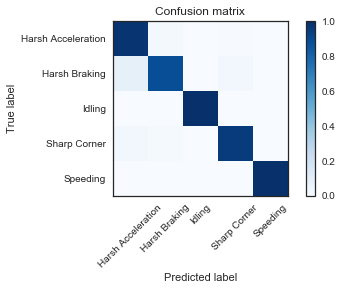

In [52]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, preds)
np.set_printoptions(precision=2)
# Plot confusion matrix
unique_type_list = ['Harsh Braking', 'Harsh Acceleration', 'Idling','Sharp Corner', 'Speeding']
lab_encoder = LabelEncoder().fit(unique_type_list)
plot_confusion_matrix(cnf_matrix, classes=lab_encoder.inverse_transform(range(5)), normalize=True,
                      title=('Confusion matrix'))

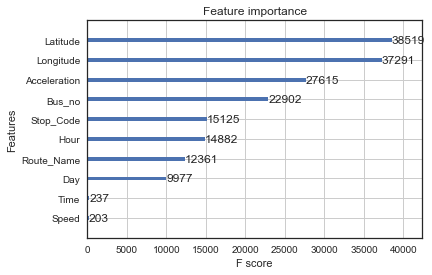

In [51]:
#Feature importance plot
xgb.plot_importance(model)

In [ ]:
#Pickle the model
filename = 'model_v1_driver_behaviour.pk'
with open('./scripts/driver_behaviour/'+filename, 'wb') as file:
	pickle.dump(model, file)